In [42]:
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import matplotlib.pyplot as plt

In [43]:
sample = 10000
bus = 9
ref_bus = 0

# Load data from csv into variables
with open('data_x_%d.csv' %bus) as xcvs:
    readCSV = csv.reader(xcvs, delimiter=',')
    data_x = np.ones([bus*3,sample])
    i = 0
    for row in readCSV:
        data_x[i,:] = row
        i = i+1
        
with open('data_y_%d.csv' %bus) as ycvs:
    readCSV = csv.reader(ycvs, delimiter=',')
    data_y = np.ones([bus*2,sample])
    i = 0
    for row in readCSV:
        data_y[i,:] = row
        i = i+1        
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   

In [44]:
# Normalize the data into range between -1 and 1

# def normalize(data):
#     x , y , z = data.shape
#     max_val = torch.reshape(torch.amax(torch.abs(data),1),(x,1,z))
#     norm = torch.divide(data,max_val)
#     norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
#     return norm, max_val

def normalize(data):
    mean_val = torch.mean(data,0,keepdim=True)
    std_val  = torch.std(data,0,keepdim=True)
    norm = data  - mean_val / std_val
    return norm, mean_val, std_val

In [47]:
# Separate generate data into  training, val, test data set
lenx , sample = data_x.shape
leny , sample = data_y.shape
num1 = int(0.8*sample)
num2 = int(0.1*sample)

train_x = torch.Tensor(data_x[:,0:num1]).transpose(0, 1)
val_x   = torch.Tensor(data_x[:,num1:(num1+num2)]).transpose(0, 1)
test_x  = torch.Tensor(data_x[:,(num1+num2):sample]).transpose(0, 1)

train_y = torch.Tensor(data_y[:,0:num1]).transpose(0, 1)
val_y   = torch.Tensor(data_y[:,num1:(num1+num2)]).transpose(0, 1)
test_y  = torch.Tensor(data_y[:,(num1+num2):sample]).transpose(0, 1)

train_x, mean_x, std_x = normalize(train_x)
train_y, mean_y, std_y = normalize(train_y)

val_x = val_x - mean_x / std_x
val_y = val_y - mean_y / std_y

test_x = test_x - mean_x / std_x
test_y = test_y - mean_y / std_y

In [48]:
Reshape the data set into correct size
train_x = train_x.reshape(num1,int(lenx/bus),bus).to(device)   
train_x = train_x.transpose(1,2)
val_x   = val_x.reshape(num2,int(lenx/bus),bus).to(device)   
val_x   = val_x.transpose(1,2)
test_x  = test_x.reshape(num2,int(lenx/bus),bus).to(device)   
test_x  = test_x.transpose(1,2)


train_y = train_y.reshape(num1,int(leny/bus),bus).to(device)   
train_y = train_y.transpose(1,2)
val_y   = val_y.reshape(num2,int(leny/bus),bus).to(device)   
val_y   = val_y.transpose(1,2)
test_y  = test_y.reshape(num2,int(leny/bus),bus).to(device)   
test_y  = test_y.transpose(1,2)

In [52]:
print(val_x.shape)

torch.Size([1000, 9, 3])


In [49]:
# Training model

class PowerFlow(nn.Module):
    def __init__(self):
        super(PowerFlow,self).__init__()
        #layer definitions
        self.FC1   = nn.Linear(bus*3,500)
        self.FC2   = nn.Linear(500,100)
        self.FC3   = nn.Linear(100,50)
        self.FC4   = nn.Linear(50,bus*2)
        self.act   = nn.LeakyReLU(0.3)

    def forward(self, x):
        x = self.act(self.FC1(x))
        x = self.act(self.FC2(x))
        x = self.act(self.FC3(x))
        x = self.FC4(x)
        return x
    
# Loss function
def MSE(ypred,ytrue):
    loss = nn.MSELoss()
#     loss = nn.L1Loss()
    return loss(ypred,ytrue)

def mean_error(ypred,ytrue,ref):
    error = torch.abs(ypred - ytrue) / torch.abs(ytrue)
    error[ytrue == 0] = torch.abs(ypred[ytrue == 0])
    mean_error = torch.mean(error)*100
    return mean_error.detach().cpu().numpy()
    

In [50]:
# Define training variables

CNNPF = PowerFlow().to(device)
optimizer = optim.SGD(CNNPF.parameters(), lr=0.0001, momentum=0.7)
# optimizer = optim.Adam(CNNPF.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-07, weight_decay=0.1, amsgrad=False)
hloss = []
train_err = []
val_err = []
n = 0
num_epochs  = 1000
batch = 250
iter = int(num1/batch)
disp = 4

# norm_train_x, max_train_x = normalize(train_x)
# norm_train_y, max_train_y = normalize(train_y)
# norm_val_x,   max_val_x   = normalize(val_x)
# norm_val_y,   max_val_y   = normalize(val_y)

# Start training
CNNPF = CNNPF.train()

for epoch in range(num_epochs):
    index = np.random.choice(num1, batch*iter, replace=False)
    index = np.reshape(index,[iter,batch])
    
    for i in range(iter):
        CNNPF = CNNPF.train()
        X = train_x[index[i,:],:]     
        Y = train_y[index[i,:],:]
        
        optimizer.zero_grad()

        # Forward + backward + optimize
        Y_pred = CNNPF(X)
        loss = MSE(Y_pred,Y)
        loss.backward()
        optimizer.step()
        n += 1
        
    if epoch % disp == 0:
    
        hloss.append(loss.detach().cpu().numpy()) 
        CNNPF = CNNPF.eval()
        pred_y = CNNPF(val_x).detach()
        error = mean_error(pred_y,val_y,ref_bus)
        val_err.append(error) 

        pred_y = CNNPF(train_x).detach()
        error = mean_error(pred_y,train_y,ref_bus)
        train_err.append(error)        

        print(loss.detach().cpu().numpy()) 


RuntimeError: mat1 dim 1 must match mat2 dim 0

Text(0.5, 1.0, 'NN - Absolute Error Rate For 24 Bus System')

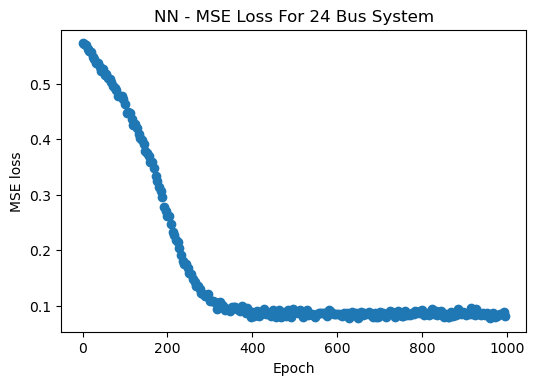

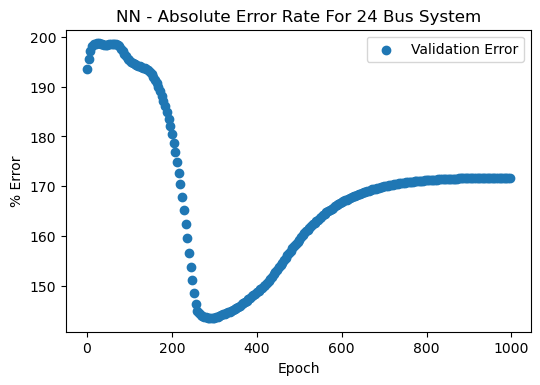

In [8]:
# Plot the result  
plt.figure(dpi=100)       
plt.scatter(range(0,num_epochs,disp),hloss)
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('NN - MSE Loss For {} Bus System'.format(bus))
# plt.savefig("NN_Loss_{}.png".format(bus))

plt.figure(dpi=100) 
# plt.scatter(range(0,num_epochs,disp),train_err, label = "Training Error")
plt.scatter(range(0,num_epochs,disp),val_err, label = 'Validation Error')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("% Error")
plt.title('NN - Absolute Error Rate For {} Bus System'.format(bus))
# plt.savefig("NN_Error_{}.png".format(bus))

In [9]:
Y = Y.reshape(batch,bus,2)
Y_pred = Y_pred.reshape(batch,bus,2)
print(Y[8,:].detach().cpu().numpy())
print(Y_pred[8,:].detach().cpu().numpy())
# print(norm_train_y[7,25].detach().cpu().numpy())

[[ 0.95280343  0.7201213 ]
 [ 0.95280343  0.7168811 ]
 [ 0.9660403   0.07641747]
 [ 0.96399045  0.22845434]
 [ 0.9765815   0.08269705]
 [ 1.         -0.5837948 ]
 [ 0.9435976   1.        ]
 [ 0.9629278   0.3822438 ]
 [ 0.97003776 -0.06496414]
 [ 0.9994372  -0.49106073]
 [ 0.93498516 -0.07314653]
 [ 0.956223   -0.2808617 ]
 [ 0.9389947   0.        ]
 [ 0.90217143  0.48980516]
 [ 0.9334713   0.01418441]
 [ 0.9362329  -0.04012338]
 [ 0.957879   -0.3869023 ]
 [ 0.96661216 -0.52204365]
 [ 0.9512215  -0.26516938]
 [ 0.9620457  -0.4189554 ]
 [ 0.96661216 -0.5218681 ]
 [ 0.96661216 -0.50460416]
 [ 0.96661216 -0.4808008 ]
 [ 0.9368264   0.00594307]]
[[ 0.93751943  0.01867461]
 [ 0.9367772  -0.01402988]
 [ 0.92798907 -0.19816926]
 [ 0.9268895  -0.24022582]
 [ 0.95823574 -0.1969245 ]
 [ 0.96977186 -0.5042447 ]
 [ 0.92490244  0.38531637]
 [ 0.9343672   0.05563568]
 [ 0.9334687  -0.3089561 ]
 [ 0.9653424  -0.35473418]
 [ 0.91135776 -0.15352903]
 [ 0.92543286 -0.20797807]
 [ 0.9293693   0.01073183]


In [10]:
# Start eval
CNNPF = CNNPF.eval()

norm_test_x,   max_test_x   = normalize(test_x)
norm_test_y,   max_test_y   = normalize(test_y)
pred_y = CNNPF(norm_test_x)
error = mean_error(pred_y,norm_test_y,ref_bus)
print(error)

256.0234


In [11]:
a = torch.rand(5,5)
b = torch.ones(5,5)
c = torch.ones(5,5)*3
b[2,2] = 0
b[3,4] = 0
print(a,b)
print(b == 0)
a[b == 0] = c[b == 0]
print(torch.mean(b))


tensor([[0.8400, 0.1617, 0.1635, 0.5273, 0.1288],
        [0.5270, 0.3845, 0.0700, 0.9484, 0.6107],
        [0.4268, 0.9736, 0.7017, 0.4810, 0.9703],
        [0.8113, 0.6995, 0.2047, 0.4645, 0.1862],
        [0.8805, 0.2911, 0.8557, 0.5731, 0.9856]]) tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])
tensor([[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False,  True, False, False],
        [False, False, False, False,  True],
        [False, False, False, False, False]])
tensor(0.9200)


In [12]:
t = torch.tensor([[1,2],[3,4]])
torch.gather(t, 1,torch.tensor([[0,0],[0,0]]))

tensor([[1, 1],
        [3, 3]])

In [21]:
t = torch.rand(4,6)
print(torch.mean(t,1,keepdim=True))
print(t)

tensor([[0.3154],
        [0.3851],
        [0.8070],
        [0.3473]])
tensor([[0.3167, 0.0791, 0.0440, 0.1489, 0.6184, 0.6854],
        [0.1914, 0.3020, 0.4351, 0.9193, 0.3000, 0.1626],
        [0.5154, 0.9262, 0.9548, 0.9286, 0.6084, 0.9088],
        [0.7483, 0.0415, 0.0668, 0.1923, 0.5501, 0.4845]])
